**Table of contents**<a id='toc0_'></a>    
- [XGB MODEL](#toc1_1_)    
  - [NII_24M](#toc1_2_)    
  - [NFI 24M](#toc1_3_)    
  - [Feature importance](#toc1_4_)    
    - [NFI](#toc1_4_1_)    
    - [NII](#toc1_4_2_)    
  - [Plot](#toc1_5_)    
    - [Risk vs NII](#toc1_5_1_)    
    - [Risk vs NFI](#toc1_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [7]:
import os
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
from datetime import datetime
from sqlalchemy import create_engine
import pyodbc
import matplotlib
wd = os.getcwd()

In [8]:
# data_test.to_csv(wd+'\\01. data\\input\\data_test.csv')
# data_train.to_csv(wd+'\\01. data\\input\\data_train.csv')

In [9]:

data_train = pd.read_csv(wd+'\\01. data\\input\\data_train.csv')
data_train['nhom_no_cic'] = data_train['nhom_no_cic'].astype('str')

data_test = pd.read_csv(wd+'\\01. data\\output\\out_put_scorecard.csv')
data_test['nhom_no_cic'] = data_test['nhom_no_cic'].astype('str')




In [10]:
data_test.columns

Index(['product_group', 'contract_limit', 'bi_card_type', 'liab_limit',
       'campaign_group', 'cus_income', 'income_tier', 'gender',
       'marital_status', 'edu_level', 'province_city', 'age', 'cus_class',
       'ovd_days', 'ovd_days_6m', 'ovd_days_12m', 'ovd_days_24m',
       'ovd_days_36m', 'nhom_no_cic', 'revolver_group', 'nii_24m', 'nfi_24m',
       'toi_24m', 'provision_24m', 'bad_flag', 'prob_of_risk_event', 'Score'],
      dtype='object')

In [11]:
data_train

# create threshold of outlier
nii_min_threshold = data_train['nii_24m'].quantile(0.01)
nii_max_threshold = data_train['nii_24m'].quantile(0.99)
nfi_min_threshold = data_train['nfi_24m'].quantile(0.01)
nfi_max_threshold = data_train['nfi_24m'].quantile(0.99)

# remove outlier
# data = data[(data['nii_24m'] > nii_min_threshold) & (data['nii_24m'] < nii_max_threshold) & (data['nfi_24m'] > nfi_min_threshold) & (data['nfi_24m'] < nfi_max_threshold)]

In [12]:
excluded_columns = data_train.columns[13:]
input_columns = [col for col in data_train.columns if col not in excluded_columns]
input_columns.extend(['nhom_no_cic'])

X_train = data_train[input_columns]
X_test = data_test[input_columns]

X = pd.concat([X_train, X_test], axis = 0)
X.reset_index(drop=True, inplace= True)

## <a id='toc1_1_'></a>[XGB MODEL](#toc0_)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Define the categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Convert categorical columns to 'category' data type
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

# Create a ColumnTransformer to apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    [('onehot', OneHotEncoder(), categorical_cols)],
    remainder='passthrough'
)

# Apply one-hot encoding to the training data
X_encoded= preprocessor.fit_transform(X)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)



In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

model = xgb.XGBRegressor()
param_grid = {
    'n_estimator': [100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.01, 0.1]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring=['neg_mean_squared_error'],
    cv=5,
    verbose=3,
    refit='neg_mean_squared_error'
)

## <a id='toc1_2_'></a>[NII_24M](#toc0_)

In [19]:
col = 'nii_24m'

y_train = data_train[col]
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 111)

grid_search.fit(X_train_encoded, y_train)


# Lưu parameter
import json
output_link = wd + '\\04. model\\' + col +'_bes_params.json'
best_params = grid_search.best_params_
with open(output_link, 'w') as file:
    json.dump(best_params, file)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-48756275815993.883) total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-47700260875257.680) total time=   0.3s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-55277037492574.836) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-57994499313236.406) total time=   0.2s
[CV 5/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-50634485136056.500) total time=   0.2s
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.9; neg_mean_squared_error: (test=-48761184688189.42

In [20]:
import pickle

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_encoded, y_train)

## predict nii
y_pred = xgb_model.predict(X_test_encoded)
data_test['nii_pred'] = y_pred

In [ ]:
data_test = 

In [22]:
# Tính toán R² và MSE
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [187425, 46790]

In [12]:
pickle.dump(xgb_model, open(wd + '\\04. model\\xgboost_model_nii.pkl', 'wb'))
feature_importance_nii = xgb_model.feature_importances_


## <a id='toc1_3_'></a>[NFI 24M](#toc0_)

In [13]:
col = 'nfi_24m'

y_train = data_train[col]
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 111)
grid_search.fit(X_train_encoded, y_train)


# Lưu parameter
import json
output_link = wd + '\\04. model\\' + col +'_bes_params.json'
best_params = grid_search.best_params_
with open(output_link, 'w') as file:
    json.dump(best_params, file)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-15880289131379.922) total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-15559887998007.250) total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-20114730837444.531) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-14202434169844.779) total time=   0.2s
[CV 5/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.8; neg_mean_squared_error: (test=-14195989624634.646) total time=   0.3s
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimator=100, subsample=0.9; neg_mean_squared_error: (test=-15884169384329.95

In [14]:
best_params

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_encoded, y_train)

## predict nfi data_test
y_pred = xgb_model.predict(X_test_encoded)
data_test['nfi_pred'] = y_pred


In [23]:
out_put_link = wd + '\\01. data\\output\\out_put_profit_xgb.csv' 
data_final = pd.read_csv(out_put_link)



In [27]:
y_train = data_final['nii_24m']
y_test = data_final['nii_pred']
# Tính toán R² và MSE
r2 = r2_score(y_train, y_test)
mse = mean_squared_error(y_train, y_test)

print(r2, mse)

0.10932835313384759 44550385262535.414


In [28]:
y_train_2 = data_final['nfi_24m']
y_test_2 = data_final['nfi_pred']
# Tính toán R² và MSE
r2 = r2_score(y_train_2, y_test_2)
mse = mean_squared_error(y_train_2, y_test_2)

print(r2, mse)

0.1879241648151896 11152436993495.744


In [15]:
out_put_link = wd + '\\01. data\\output\\out_put_profit_xgb.csv' 
data_test.to_csv(out_put_link, index=False)

In [16]:
pickle.dump(xgb_model, open(wd + '\\04. model\\xgboost_model_nfi.pkl', 'wb'))
feature_importance_nfi = xgb_model.feature_importances_

## <a id='toc1_4_'></a>[Feature importance](#toc0_)

### <a id='toc1_4_1_'></a>[NFI](#toc0_)

In [1]:
import xgboost
import pickle

In [4]:
xgboost_model_nfi = pickle.load(open(wd + '\\04. model\\xgboost_model_nfi.pkl', 'rb'))
feature_importance = xgboost_model_nfi.feature_importances_

<bound method XGBModel.fit of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=100, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)>


In [18]:

importance_dict = dict(zip(input_columns, feature_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)
sorted_importance

[('income_tier', 0.0),
 ('gender', 0.0),
 ('province_city', 0.0),
 ('campaign_group', 0.0021380219),
 ('product_group', 0.0021888546),
 ('marital_status', 0.0069340155),
 ('bi_card_type', 0.008552635),
 ('liab_limit', 0.009295698),
 ('nhom_no_cic', 0.014302422),
 ('cus_class', 0.029379237),
 ('cus_income', 0.03215486),
 ('edu_level', 0.057341635),
 ('age', 0.07414844),
 ('contract_limit', 0.11446403)]

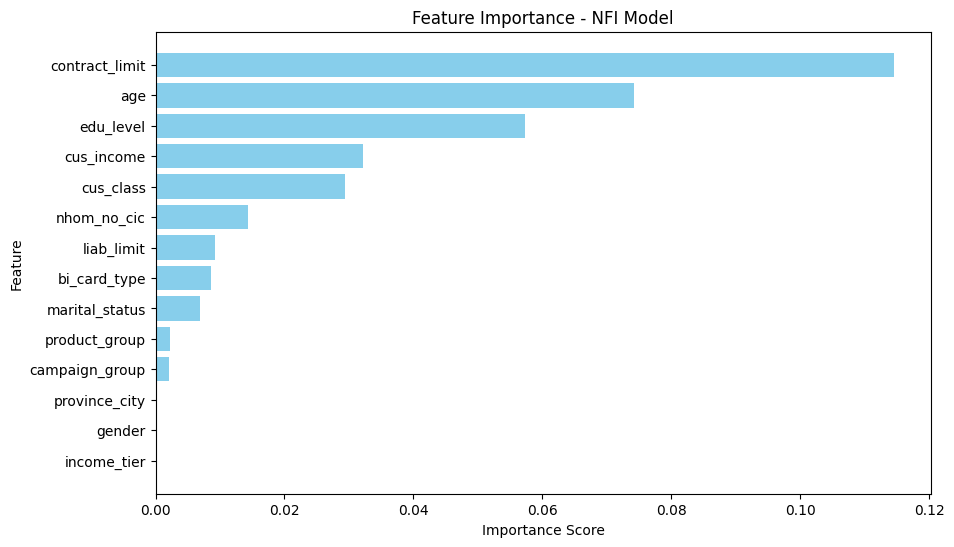

In [19]:
from matplotlib import pyplot as plt
# Tách dữ liệu thành tên biến và độ quan trọng
feature_names, importance_scores = zip(*sorted_importance)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importance_scores, align='center', color='skyblue')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance - NFI Model')
plt.show()

### <a id='toc1_4_2_'></a>[NII](#toc0_)

In [20]:
xgboost_model_nii = pickle.load(open(wd + '\\04. model\\xgboost_model_nii.pkl', 'rb'))
feature_importance = xgboost_model_nii.feature_importances_

In [21]:

importance_dict = dict(zip(input_columns, feature_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)
sorted_importance

[('province_city', 0.0),
 ('income_tier', 0.0020055538),
 ('nhom_no_cic', 0.002376292),
 ('campaign_group', 0.0024487197),
 ('contract_limit', 0.0037397544),
 ('cus_income', 0.0067577963),
 ('gender', 0.00692207),
 ('cus_class', 0.00738471),
 ('product_group', 0.0077074547),
 ('edu_level', 0.008357829),
 ('bi_card_type', 0.00844066),
 ('marital_status', 0.009248581),
 ('age', 0.013135943),
 ('liab_limit', 0.0134411855)]

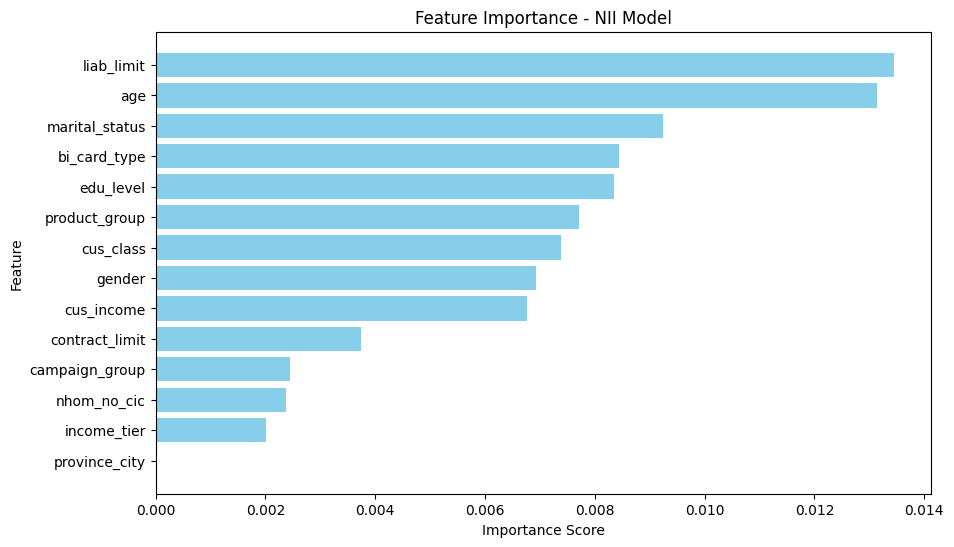

In [22]:

# Tách dữ liệu thành tên biến và độ quan trọng
feature_names, importance_scores = zip(*sorted_importance)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importance_scores, align='center', color='skyblue')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance - NII Model')
plt.show()

## <a id='toc1_5_'></a>[Plot](#toc0_)

In [23]:
out_put_link = wd + '\\01. data\\output\\out_put_profit_xgb.csv' 
data_final = pd.read_csv(out_put_link)

In [24]:
data_final = pd.read_csv(out_put_link)
plt_data = data_final[['nii_24m', 'nii_pred', 'nfi_24m', 'nfi_pred', 'prob_of_risk_event']]

In [25]:
plt_data['prob_of_risk_event'] = round(plt_data['prob_of_risk_event'], 1)
plt_data = plt_data.dropna()

### <a id='toc1_5_1_'></a>[Risk vs NII](#toc0_)

In [26]:
quantiles = plt_data.groupby("prob_of_risk_event")[["nii_pred", "nii_24m"]].quantile([0.25, 0.75])
counts = plt_data.groupby("prob_of_risk_event")[["nii_pred", "nii_24m"]].count()


# Hiển thị bảng quantiles với cột count
print(quantiles)

                             nii_pred       nii_24m
prob_of_risk_event                                 
0.0                0.25  1.220509e+06 -9.845909e+03
                   0.75  3.065878e+06  2.456443e+06
0.1                0.25  5.890682e+05  0.000000e+00
                   0.75  1.630380e+06  4.271325e+04
0.2                0.25  9.399361e+05  0.000000e+00
                   0.75  2.521512e+06  1.438686e+06
0.3                0.25  1.605626e+06  0.000000e+00
                   0.75  3.507002e+06  4.011342e+06
0.4                0.25  1.781446e+06  0.000000e+00
                   0.75  3.639343e+06  4.425319e+06
0.5                0.25  1.647114e+06  0.000000e+00
                   0.75  3.943030e+06  3.708281e+06
0.6                0.25  1.634514e+06  0.000000e+00
                   0.75  3.872389e+06  3.556877e+06
0.7                0.25  1.565151e+06  0.000000e+00
                   0.75  3.061425e+06  3.345877e+06
0.8                0.25  1.054403e+06  0.000000e+00
            

In [27]:
quantiles
counts

,nii_pred,nii_24m
prob_of_risk_event,,
0.0,37969,37969
0.1,1581,1581
0.2,1878,1878
0.3,1860,1860
0.4,1672,1672
0.5,1167,1167
0.6,449,449
0.7,78,78
0.8,84,84


In [28]:
result_df = quantiles.unstack().reset_index()
result_df.columns = ["prob_of_risk_event", "q25_nii_pred", "q75_nii_pred","q25_nii_act", "q75_nii_act" ]
# result_df

result_df

,prob_of_risk_event,q25_nii_pred,q75_nii_pred,q25_nii_act,q75_nii_act
0,0.0,1.220509e+06,3065878.000,-9845.9092,2.456443e+06
1,0.1,5.890682e+05,1630380.200,0.0000,4.271325e+04
2,0.2,9.399361e+05,2521512.150,0.0000,1.438686e+06
3,0.3,1.605626e+06,3507002.150,0.0000,4.011342e+06
4,0.4,1.781446e+06,3639342.800,0.0000,4.425319e+06
5,0.5,1.647114e+06,3943030.400,0.0000,3.708281e+06
6,0.6,1.634514e+06,3872389.000,0.0000,3.556877e+06
7,0.7,1.565151e+06,3061424.800,0.0000,3.345877e+06
8,0.8,1.054403e+06,3229518.825,0.0000,2.118797e+06
9,0.9,9.116043e+05,3837138.625,-250.2780,1.715392e+06


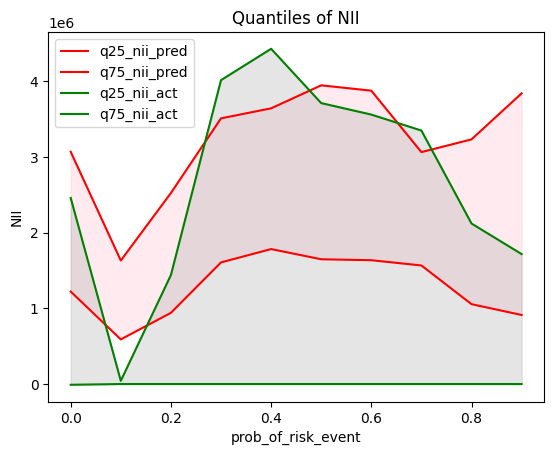

In [29]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ đường
plt.plot(result_df['prob_of_risk_event'], result_df['q25_nii_pred'], label='q25_nii_pred', color='red')
plt.plot(result_df['prob_of_risk_event'], result_df['q75_nii_pred'], label='q75_nii_pred', color='red')

plt.plot(result_df['prob_of_risk_event'], result_df['q25_nii_act'], label='q25_nii_act', color='green')
plt.plot(result_df['prob_of_risk_event'], result_df['q75_nii_act'], label='q75_nii_act', color='green')


# Đặt nhãn cho trục x và trục y
plt.xlabel('prob_of_risk_event')
plt.ylabel('NII')

# Đổ màu khu vực giữa hai đường q25 và q75
plt.fill_between(result_df['prob_of_risk_event'], result_df['q25_nii_pred'], result_df['q75_nii_pred'], color='pink', alpha=0.3)
plt.fill_between(result_df['prob_of_risk_event'], result_df['q25_nii_act'], result_df['q75_nii_act'], color='darkgrey', alpha=0.3)

# Đặt tiêu đề cho biểu đồ
plt.title('Quantiles of NII')

# Hiển thị chú thích
plt.legend()



# Hiển thị biểu đồ
plt.show()

### <a id='toc1_5_2_'></a>[Risk vs NFI](#toc0_)


In [30]:
quantiles = plt_data.groupby("prob_of_risk_event")[["nfi_pred", "nfi_24m"]].quantile([0.25, 0.75])
counts = plt_data.groupby("prob_of_risk_event")[["nfi_pred", "nfi_24m"]].count()


# Hiển thị bảng quantiles với cột count
print(quantiles)

                            nfi_pred       nfi_24m
prob_of_risk_event                                
0.0                0.25   805709.600  1.008800e+04
                   0.75  2403307.800  2.230124e+06
0.1                0.25   279972.720  0.000000e+00
                   0.75  1147721.500  7.080620e+05
0.2                0.25   345706.400  0.000000e+00
                   0.75  1296044.225  1.168495e+06
0.3                0.25   542188.935  0.000000e+00
                   0.75  1609240.925  1.620342e+06
0.4                0.25   586476.475  0.000000e+00
                   0.75  1575903.575  1.652891e+06
0.5                0.25   545917.430  0.000000e+00
                   0.75  1132065.000  1.324019e+06
0.6                0.25   556516.440  0.000000e+00
                   0.75   847138.000  1.166003e+06
0.7                0.25   502515.775  0.000000e+00
                   0.75   790666.700  1.139590e+06
0.8                0.25   388816.350  0.000000e+00
                   0.75   88445

In [31]:
result_df = quantiles.unstack().reset_index()
result_df.columns = ["prob_of_risk_event", "q25_nfi_pred", "q75_nfi_pred","q25_nfi_act", "q75_nfi_act" ]
# result_df

result_df

,prob_of_risk_event,q25_nfi_pred,q75_nfi_pred,q25_nfi_act,q75_nfi_act
0,0.0,805709.600,2403307.800,10088.0,2.230124e+06
1,0.1,279972.720,1147721.500,0.0,7.080620e+05
2,0.2,345706.400,1296044.225,0.0,1.168495e+06
3,0.3,542188.935,1609240.925,0.0,1.620342e+06
4,0.4,586476.475,1575903.575,0.0,1.652891e+06
5,0.5,545917.430,1132065.000,0.0,1.324019e+06
6,0.6,556516.440,847138.000,0.0,1.166003e+06
7,0.7,502515.775,790666.700,0.0,1.139590e+06
8,0.8,388816.350,884450.940,0.0,1.652131e+06
9,0.9,353420.185,921053.555,0.0,6.807108e+05


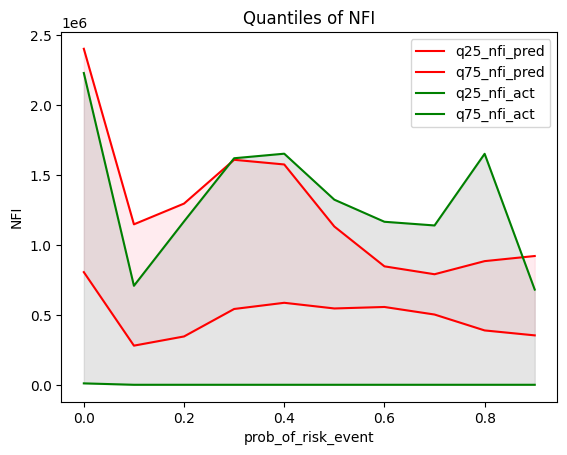

In [32]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ đường
plt.plot(result_df['prob_of_risk_event'], result_df['q25_nfi_pred'], label='q25_nfi_pred', color='red')
plt.plot(result_df['prob_of_risk_event'], result_df['q75_nfi_pred'], label='q75_nfi_pred', color='red')

plt.plot(result_df['prob_of_risk_event'], result_df['q25_nfi_act'], label='q25_nfi_act', color='green')
plt.plot(result_df['prob_of_risk_event'], result_df['q75_nfi_act'], label='q75_nfi_act', color='green')


# Đặt nhãn cho trục x và trục y
plt.xlabel('prob_of_risk_event')
plt.ylabel('NFI')

# Đổ màu khu vực giữa hai đường q25 và q75
plt.fill_between(result_df['prob_of_risk_event'], result_df['q25_nfi_pred'], result_df['q75_nfi_pred'], color='pink', alpha=0.3)
plt.fill_between(result_df['prob_of_risk_event'], result_df['q25_nfi_act'], result_df['q75_nfi_act'], color='darkgrey', alpha=0.3)

# Đặt tiêu đề cho biểu đồ
plt.title('Quantiles of NFI')

# Hiển thị chú thích
plt.legend()



# Hiển thị biểu đồ
plt.show()